# Usaremos el output del modelo CNN como características input del Árbol de Decisión

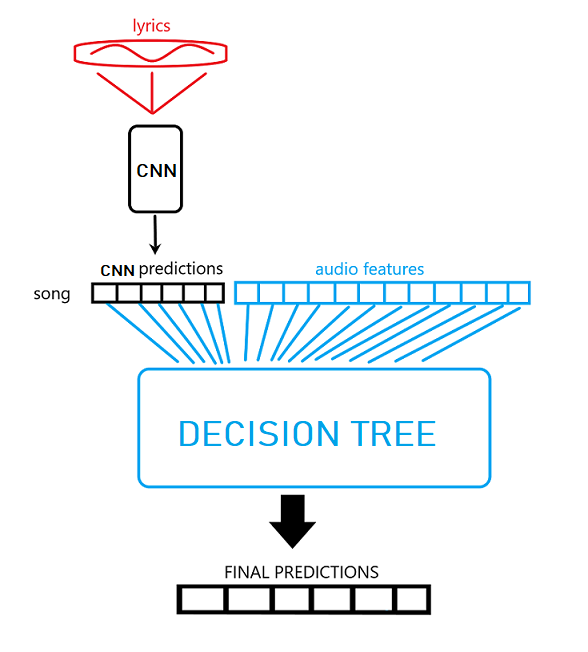

In [1]:
import pandas as pd

df_audio_features = pd.read_csv('/kaggle/input/5ms-upgrade/5MS_audio_features.csv', index_col=0)
df_5MS = pd.read_csv('/kaggle/input/5ms-upgrade/final_5MS.csv', index_col=0)

In [2]:
df_audio_features = df_audio_features.merge(df_5MS, how='right', right_on='id', left_on='id')[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'tag', 'id']]
df_audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,tag,id
0,0.485,0.710,7.0,-6.288,1.0,0.3640,0.0444,0.000000,0.3500,0.473,170.942,316267.0,rap,2tQM1BUrXp2kqOM6mN11TC
1,0.828,0.654,10.0,-8.348,0.0,0.0784,0.1520,0.000000,0.0563,0.862,93.007,247827.0,rap,04kvMnJ6zo72bSnZDWyE7m
2,0.889,0.818,9.0,-4.639,1.0,0.2530,0.4700,0.000000,0.1790,0.782,96.063,302760.0,rap,5ByAIlEEnxYdvpnezg7HTX
3,0.612,0.850,1.0,-4.703,1.0,0.5000,0.0393,0.000000,0.2550,0.781,173.497,204027.0,rap,1Z7C8ClE8UEaH70jCCeJH2
4,0.792,0.694,8.0,-8.496,0.0,0.3300,0.0619,0.000023,0.2500,0.804,177.094,309773.0,rap,4LGMSdeKOUoy5Wf75Je0Hl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302213,0.417,0.327,7.0,-12.678,1.0,0.0321,0.6530,0.608000,0.2290,0.394,84.681,167400.0,rb,29EAgZQVXMQwm2O81MffjV
302214,0.309,0.871,5.0,-3.556,1.0,0.0867,0.0972,0.000000,0.1970,0.550,84.574,191478.0,country,46XuJOFMgB1biZv3rztHpT
302215,0.632,0.188,11.0,-13.764,0.0,0.0364,0.6640,0.002970,0.4810,0.573,88.876,123200.0,rb,6yItLFQtv1NVafUWSkmE2S
302216,0.352,0.790,2.0,-2.915,1.0,0.0319,0.0719,0.000000,0.0714,0.320,74.973,200000.0,pop,2bVh1aGyCWxKkZvEn61xZ1


In [3]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

df_audio_features['tag']= label_encoder.fit_transform(df_audio_features['tag'])
label_encoder.classes_

array(['country', 'misc', 'pop', 'rap', 'rb', 'rock'], dtype=object)

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_audio_features[columns], df_audio_features.tag, test_size=0.2, random_state=1)

print(f"Training data samples: {len(x_train)}")
print(f"Test data samples: {len(x_test)}")

Training data samples: 241774
Test data samples: 60444


# TO DO: AGREGAR LA SALIDA DE CNN COMO COLUMNAS DE AUDIO FEATURES

In [5]:
cnn_train_preds = pd.read_csv("/kaggle/input/cnn-results/predicts_vs_real_TRAIN.csv", index_col=0)
print('Train checker:', all(y_train.values == cnn_train_preds.tag.values))
cnn_train_preds.drop(columns='tag', inplace=True)

cnn_test_preds = pd.read_csv("/kaggle/input/cnn-results/predicts_vs_real_TEST.csv", index_col=0)
print('Test checker:', all(y_test.values == cnn_test_preds.tag.values))
cnn_test_preds.drop(columns='tag', inplace=True)

Train checker: True
Test checker: True


In [6]:
x_train = pd.concat([x_train, cnn_train_preds.set_index(x_train.index)], axis=1)
x_test = pd.concat([x_test, cnn_test_preds.set_index(x_test.index)], axis=1)

# TO DO: CONSTRUCCION DE UN MODELO
1. pipeline de preprocesamiento
2. modelo

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

transformer = Pipeline([('imputer', SimpleImputer()), ('scaler', StandardScaler())])
transformer

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [8]:
import numpy as np
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

dt_model = tree.DecisionTreeClassifier();
churn_pipe_tree = Pipeline(steps=[('prep', transformer), ('clas', dt_model)])

churn_pipe_tree.fit(x_train, y_train)
print('Accuracy sin ajuste de hiperparámetros:', churn_pipe_tree.score(x_test, y_test))

parameters = {}
parameters['prep__imputer__strategy'] = ['mean', 'median']
parameters['clas__max_depth'] = [None, 3, 5, 7, 9]
parameters['clas__class_weight'] = [None, 'balanced']

GS = GridSearchCV(churn_pipe_tree, parameters, scoring='accuracy')
GS.fit(x_train, y_train)

churn_pipe_tree = GS.best_estimator_

pred_probs = churn_pipe_tree.predict_proba(x_test)
y_test_pred = np.argmax(pred_probs, axis=1)
report = classification_report(y_test, y_test_pred, output_dict=True)

print('\nTras el ajuste de hiperparámetros:')
pd.DataFrame(report).T

Accuracy sin ajuste de hiperparámetros: 0.48044470915227316

Tras el ajuste de hiperparámetros:


,precision,recall,f1-score,support
0,0.634727,0.773094,0.697111,14138.000000
1,0.703833,0.238067,0.355790,3394.000000
2,0.335614,0.201932,0.252150,11905.000000
3,0.736635,0.705550,0.720758,7441.000000
4,0.474650,0.643046,0.546162,10584.000000
5,0.580799,0.601602,0.591017,12982.000000
accuracy,0.562636,0.562636,0.562636,0.562636
macro avg,0.577709,0.527215,0.527165,60444.000000
weighted avg,0.552627,0.562636,0.543999,60444.000000
